In [2]:
from __future__ import division

In [1]:
pip install --upgrade pyarrow==0.17.0

Looking in indexes: https://pypi.org/simple, https://nexus3.sqcorp.co/repository/pypi-all/simple
Requirement already up-to-date: pyarrow==0.17.0 in /usr/local/lib/python3.7/site-packages (0.17.0)
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [78]:
 pip install statsmodels 

Looking in indexes: https://pypi.org/simple, https://nexus3.sqcorp.co/repository/pypi-all/simple
     |████████████████████████████████| 9.5 MB 791 kB/s eta 0:00:01
     |████████████████████████████████| 231 kB 72.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [208]:
import pandas as pd
import numpy as np

from pydumbo import merchant_signals as MerchantSignals
from kplib.dumbo import Dumbo, DataframeInput, FeatureOptions,EvaluationOptions

from sklearn.metrics import euclidean_distances
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp

from pysnowflake.simple import Session
from pysnowflake.utils import retrieve_query
from pysnowflake.utils import write_df_to_snowflake

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn import metrics
import blocks
from blocks.filesystem import GCSFileSystem

pd.options.display.max_columns = 25
pd.options.display.max_rows = 25
pd.set_option('display.float_format', '{:.2f}'.format)
pd.options.display.max_rows = 100

In [210]:
class LookAlike(object):
    def __init__(self, independent_variable, similarity_date, signup_date_end,
                 post_measurement_date, sampled_ratio):
        if (pd.to_datetime(post_measurement_date) - pd.to_datetime(signup_date_end)).days < 28:
            raise ValueError('Need at least 28 days between signup_date_end and post_measurement_date')

        self.independent_variable = independent_variable
        self.similarity_date = similarity_date
        self.signup_date_end = signup_date_end
        self.post_measurement_date = post_measurement_date
        self.sampled_ratio = sampled_ratio

    @property
    def input_query(self):
        q = """
        SELECT
        dpums.user_token AS best_available_merchant_token
        , attached_later.first_attached_date
        , CASE WHEN attached_later.first_attached_date IS NOT NULL THEN 1
               WHEN already_attached.first_attached_date IS NOT NULL THEN -1
               ELSE 0 END AS is_attached_later
        , '2020-05-01' AS signal_date
        FROM app_bi.pentagon.aggregate_seller_daily_payment_summary dpums
        JOIN payments_dw.public.payment_transactions dw
        on dw.unit_token = dpums.user_token
        and payment_trx_recognized_at between  DATE('{SIMILARITY_DATE}') and DATE('{signup_date_end}') 
        and is_gpv = 1
        LEFT JOIN (
            {attachment_definition}
            {not_attached}
        ) already_attached
          ON already_attached.best_available_merchant_token = dpums.user_token
        LEFT JOIN (
            {attachment_definition}
            {attached}
        ) attached_later
        ON attached_later.best_available_merchant_token = dpums.user_token
        LEFT JOIN app_risk.app_risk.fake_account_merchants fam
          ON dpums.user_token = fam.user_token
        LEFT JOIN app_bi.pentagon.dim_user du
          ON dpums.user_token = du.user_token
        WHERE dpums.payment_trx_recognized_date BETWEEN DATE('{SIMILARITY_DATE}') - INTERVAL '30 days' AND DATE('{SIMILARITY_DATE}')
        AND dpums.currency_code in ( 'USD')
        AND gpv_payment_count > 0
        AND fam.user_token IS NULL
        AND (PAY_WITH_SQUARE_ENTRY_METHOD ILIKE '%EXTERNAL_API%' OR PAY_WITH_SQUARE_ENTRY_METHOD ILIKE 'EGIFT_PURCHASE_KEYED')
        GROUP BY 1,2,3
        """.format(attachment_definition=self.attachment_definition,
                   attached=self.attached,
                   not_attached=self.not_attached,
                   SIMILARITY_DATE=self.similarity_date,
                   signup_date_end=self.signup_date_end)
        return q

    @property
    def attachment_definition(self):
        return NotImplementedError

    @property
    def attached(self):
        return NotImplementedError

    @property
    def not_attached(self):
        return NotImplementedError
## get the seller tokens
    def prepare_initial_data(self):
        with Session() as ss:
            self.initial_data = ss.execute(self.input_query)

            
## get the signals for seller tokens
    def attach_dumbo_signals(self):
        self.sampled_data = pd.concat([self.initial_data[self.initial_data.is_attached_later == 1],
                                       self.initial_data[self.initial_data.is_attached_later == 0].sample(
                                           (self.initial_data.is_attached_later == 1).sum() * self.sampled_ratio
                                       )])
        #self.sampled_data['signal_date'] = pd.to_datetime(self.sampled_data.signal_date)
        self.sampled_data['is_attached_later'] =  self.sampled_data['is_attached_later'].astype(str)
        df = self.sampled_data
        
        ##self.all_data = MerchantSignals(df, timestamp='signal_date', tokens='best_available_merchant_token', cloud=True)
        
        signallist = [ #api based cnp amount # avg tickect size , #mcc , # currency , % of fraud chargebacks , chargeback rate, cp and cnp to rate
            ##'activation_ip_is_countrycode_usa_by_master_merchant_from_master_merchant_token',


        #avg ticket size
            'avg_capture_amount_by_merchant_from_merchant_token',
        ##amount based
            'total_amount_by_merchant_from_merchant_token',
            'total_external_api_amount_by_merchant_from_merchant_token',
            'total_success_amount_b_in_1w_by_merchant_from_merchant_token',
            #'total_success_amount_b_in_26w_by_merchant_from_merchant_token',
            #'total_success_amount_b_in_52w_by_merchant_from_merchant_token',
            'total_success_amount_b_in_13w_by_merchant_from_merchant_token',
            'total_success_amount_b_in_9w_by_merchant_from_merchant_token',
            'total_success_amount_b_in_4w_by_merchant_from_merchant_token',
            #'total_cp_amount_by_merchant_from_merchant_token',
            #'total_cnp_amount_by_merchant_from_merchant_token',
            #'total_success_amount_by_merchant_from_merchant_token',
            'total_declined_amount_by_merchant_from_merchant_token',
            'total_declined_amount_b_in_4w_by_merchant_from_merchant_token',
            'total_refund_amount_by_merchant_from_merchant_token',
        #count based 
            'total_count_by_merchant_from_merchant_token',
            'total_external_api_count_by_merchant_from_merchant_token',
            #'total_success_count_by_merchant_from_merchant_token',
            'total_declined_count_by_merchant_from_merchant_token',
            #'total_cp_success_count_by_merchant_from_merchant_token',
            #'total_cnp_success_count_by_merchant_from_merchant_token',
        #tenure
            'external_api_unique_active_days_by_merchant_from_merchant_token',
            'total_active_day_count_b_in_52w_by_merchant_from_merchant_token',
            'total_active_day_count_by_merchant_from_merchant_token',
            'millis_since_activation_by_merchant_from_merchant_token',
            #'unique_active_days_by_merchant_from_merchant_token',
        #fraud
            'total_fraud_chargeback_v4_amount_by_merchant_from_merchant_token',
            'total_non_fraud_chargeback_v4_amount_by_merchant_from_merchant_token',
            'total_fraud_chargeback_v3_count_by_merchant_from_merchant_token',
            'total_non_fraud_chargeback_v3_count_by_merchant_from_merchant_token',
        # ratio of cp/cnp
            'cp_rate_by_amount_by_merchant_from_merchant_token',
            'cp_rate_by_count_by_merchant_from_merchant_token',
            'cnp_rate_by_amount_by_merchant_from_merchant_token',
            'cnp_rate_by_count_by_merchant_from_merchant_token',
        # no of entry methods used
            'unique_entry_methods_successful_capture_by_merchant_from_merchant_token',
            #mcc
            'business_type_is_religious_organization_by_merchant_from_merchant_token',
            'business_type_is_heating_plumbing_and_air_conditioning_by_merchant_from_merchant_token',
            'business_type_is_recreation_services_by_merchant_from_merchant_token',
            'business_type_is_legal_services_by_merchant_from_merchant_token',
            'business_type_is_medical_services_and_health_practitioners_by_merchant_from_merchant_token',
            'business_type_is_beauty_and_barber_shops_by_merchant_from_merchant_token',
            'business_type_is_hobby_shop_by_merchant_from_merchant_token',
            'business_type_is_cultural_attractions_by_merchant_from_merchant_token',
            'business_type_is_clothing_shoe_repair_alterations_by_merchant_from_merchant_token',
            'business_type_is_other_by_merchant_from_merchant_token',
            'business_type_is_cleaning_services_by_merchant_from_merchant_token',
            'business_type_is_sporting_goods_by_merchant_from_merchant_token',
            'business_type_is_furniture_home_goods_by_merchant_from_merchant_token',
            'business_type_is_schools_and_educational_services_by_merchant_from_merchant_token',
            'business_type_is_veterinary_services_by_merchant_from_merchant_token',
            'business_type_is_business_services_by_merchant_from_merchant_token',
            'business_type_is_food_stores_convenience_stores_and_specialty_markets_by_merchant_from_merchant_token',
            'business_type_is_landscaping_and_horticultural_services_by_merchant_from_merchant_token',
            'business_type_is_flowers_and_gifts_by_merchant_from_merchant_token',
            'business_type_is_optometrist_eye_care_by_merchant_from_merchant_token',
            'business_type_is_pest_control_by_merchant_from_merchant_token',
            'business_type_is_electrical_services_by_merchant_from_merchant_token',
            'business_type_is_charitible_orgs_by_merchant_from_merchant_token',
            'business_type_is_food_truck_cart_by_merchant_from_merchant_token',
            'business_type_is_cleaning_by_merchant_from_merchant_token',
            'business_type_is_hardware_store_by_merchant_from_merchant_token',
            'business_type_is_watch_jewelry_repair_by_merchant_from_merchant_token',
            'business_type_is_sporting_events_by_merchant_from_merchant_token',
            'business_type_is_membership_clubs_by_merchant_from_merchant_token',
            'business_type_is_accounting_by_merchant_from_merchant_token',
            'business_type_is_professional_services_by_merchant_from_merchant_token',
            'business_type_is_repair_shops_and_related_services_by_merchant_from_merchant_token',
            'business_type_is_membership_organizations_by_merchant_from_merchant_token',
            'business_type_is_real_estate_by_merchant_from_merchant_token',
            'business_type_is_pet_store_by_merchant_from_merchant_token',
            'business_type_is_charitable_social_service_organizations_by_merchant_from_merchant_token',
            'business_type_is_web_dev_design_by_merchant_from_merchant_token',
            'business_type_is_electronics_by_merchant_from_merchant_token',
            'business_type_is_utilities_by_merchant_from_merchant_token',
            'business_type_is_child_care_by_merchant_from_merchant_token',
            'business_type_is_bar_club_lounge_by_merchant_from_merchant_token',
            'business_type_is_outdoor_markets_by_merchant_from_merchant_token',
            'business_type_is_coffee_tea_shop_by_merchant_from_merchant_token',
            'business_type_is_art_design_and_photography_by_merchant_from_merchant_token',
            'business_type_is_medical_practitioners_by_merchant_from_merchant_token',
            'business_type_is_contractors_by_merchant_from_merchant_token',
            'business_type_is_retail_shops_by_merchant_from_merchant_token',
            'business_type_is_jewelry_and_watches_by_merchant_from_merchant_token',
            'business_type_is_individual_use_by_merchant_from_merchant_token',
            'business_type_is_health_and_beauty_spas_by_merchant_from_merchant_token',
            'business_type_is_books_mags_music_and_video_by_merchant_from_merchant_token',
            'business_type_is_delivery_moving_and_storage_by_merchant_from_merchant_token',
            'business_type_is_taxicabs_and_limousines_by_merchant_from_merchant_token',
            'business_type_is_roofing_siding_and_sheet_metal_work_contractors_by_merchant_from_merchant_token',
            'business_type_is_special_trade_contractors_by_merchant_from_merchant_token',
            'business_type_is_catering_by_merchant_from_merchant_token',
            'business_type_is_grocery_market_by_merchant_from_merchant_token',
            'business_type_is_computer_equipment_software_maintenance_repair_services_by_merchant_from_merchant_token',
            'business_type_is_political_organizations_by_merchant_from_merchant_token',
            'business_type_is_art_dealers_galleries_by_merchant_from_merchant_token',
            'business_type_is_office_supply_by_merchant_from_merchant_token',
            'business_type_is_carpet_cleaning_by_merchant_from_merchant_token',
            'business_type_is_clothing_and_accessories_by_merchant_from_merchant_token',
            'business_type_is_dry_cleaning_and_laundry_by_merchant_from_merchant_token',
            'business_type_is_theatrical_arts_by_merchant_from_merchant_token',
            'business_type_is_bakery_by_merchant_from_merchant_token',
            'business_type_is_tourism_by_merchant_from_merchant_token',
            'business_type_is_consultant_by_merchant_from_merchant_token',
            'business_type_is_personal_services_by_merchant_from_merchant_token',
            'business_type_is_apparel_and_accessory_shops_by_merchant_from_merchant_token',
            'business_type_is_printing_services_by_merchant_from_merchant_token',
            'business_type_is_education_by_merchant_from_merchant_token',
            'business_type_is_eyewear_by_merchant_from_merchant_token',
            'business_type_is_restaurants_by_merchant_from_merchant_token',
            'business_type_is_dentistry_by_merchant_from_merchant_token',
            'business_type_is_music_and_entertainment_by_merchant_from_merchant_token',
            'business_type_is_misc_retail_by_merchant_from_merchant_token',
            'business_type_is_movies_film_by_merchant_from_merchant_token',
            'business_type_is_automotive_services_by_merchant_from_merchant_token']
        
        feature_options = FeatureOptions(
                            features=signallist,
                            ignore_non_synchronous=True,
                            include_deprecated=True,
                            include_for_rules_only=True
                        )

        evaluation_options = EvaluationOptions(
            skip_right_to_be_forgotten=True,
            skip_unknown_tokens=True
        )

        self.dumbo_call = Dumbo().get_features(
                "REGISTER_MERCHANT",
                DataframeInput(df=df, token_col="best_available_merchant_token", timestamp_col="signal_date",),
                point_in_time=True,
                output_path="gs://ds-risk-prod-snowstage/nmavani/lookalike/data_dumbo_v3",
                feature_options=feature_options,
                evaluation_options=evaluation_options,
                execute_in_parallel=True
        )

    def read_dumbo_values(self):
        self.all_data = blocks.assemble('gs://ds-risk-prod-snowstage/nmavani/lookalike/data_dumbo_v3/results')
        self.all_data.dropna(axis='columns', how='all', inplace=True)
        self.all_data.is_attached_later =  self.all_data.is_attached_later.astype(int)
        #self.all_data = self.all_data[signallist]
        
        
## Process data for NUll values, and transform into logged transformation for better handling distances for normalization
    def process_data(self):
        pipe = Pipeline([
            ('median_imputer', SimpleImputer(strategy='median')),
            ('standard_scaler', StandardScaler()),
            ('variance_threshold', VarianceThreshold(threshold=.1)),
        ])
        non_numeric_cols = [
            'best_available_merchant_token',
            'first_attached_date',
            'is_attached_later',
            'signal_date',
            'unit_token',
        ]
        numeric_cols = [c for c in self.all_data.columns if c not in non_numeric_cols]
        self.df_wzero = self.all_data[numeric_cols]
        self.df_nozero = self.df_wzero.mask(self.df_wzero==0).fillna(0.0000000001)
        logged_df = np.log(self.df_nozero)

        new = pipe.fit_transform(
            logged_df
        )
        selected_features = [numeric_cols[i] for i in range(len(numeric_cols)) if pipe.steps[2][1].get_support()[i]]
        new_df = pd.DataFrame(new, columns=selected_features)
        new_df.index = self.all_data['best_available_merchant_token']
        self.processed_data = new_df

##find the lookalike
    def find_lookalike_with_replacement(self):
        attached = self.processed_data[self.all_data.set_index('best_available_merchant_token')['is_attached_later'] == 1]
        non_attached = self.processed_data[self.all_data.set_index('best_available_merchant_token')['is_attached_later'] == 0]
        distance_matrix = pd.DataFrame(euclidean_distances(attached, non_attached),
                                       index=attached.index,
                                       columns=non_attached.index)
        self.neighbors_result = distance_matrix.apply(lambda x: x.idxmin(), axis=1)

#query for measuring metrics       
    measurement_query = """
            SELECT
              asdps.user_token AS best_available_merchant_token
            , SUM(CASE WHEN payment_trx_recognized_date
                            BETWEEN DATE('{SIMILARITY_DATE}') - INTERVAL '27 days' AND DATE('{SIMILARITY_DATE}')
                       THEN gpv_payment_amount_base_unit_usd / 100 ELSE 0 END) AS gpv_pre
            , SUM(CASE WHEN payment_trx_recognized_date
                            BETWEEN DATE('{POST_MEASUREMENT_DATE}') - INTERVAL '27 days' AND DATE('{POST_MEASUREMENT_DATE}')
                       THEN gpv_payment_amount_base_unit_usd / 100 ELSE 0 END) AS gpv_post
            FROM app_bi.pentagon.aggregate_seller_daily_payment_summary asdps
            WHERE asdps.user_token IN ({tokens})
            GROUP BY 1
        """

    def find_result(self):
        ATTACHED = ', '.join(["'" + v + "'" for v in self.neighbors_result.index.tolist()])
        NEIGHBORS_DUMBO = ', '.join(["'" + v + "'" for v in self.neighbors_result.values])

        with Session() as ss:
            result_attached = ss.execute(
                self.measurement_query.format(
                    tokens=ATTACHED,
                    SIMILARITY_DATE=self.similarity_date,
                    POST_MEASUREMENT_DATE=self.post_measurement_date))
            result_neighbors = ss.execute(
                self.measurement_query.format(
                    tokens=NEIGHBORS_DUMBO,
                    SIMILARITY_DATE=self.similarity_date,
                    POST_MEASUREMENT_DATE=self.post_measurement_date))

        result_attached.set_index('best_available_merchant_token', inplace=True)
        result_neighbors.set_index('best_available_merchant_token', inplace=True)
        
        result_neighbors['weight'] = self.neighbors_result.value_counts()
        result_neighbors['weighted_gpv_pre'] = result_neighbors['gpv_pre'] * result_neighbors['weight']
        result_neighbors['weighted_gpv_post'] = result_neighbors['gpv_post'] * result_neighbors['weight']

        self.attached_measurement = result_attached
        self.neighbors_measurement = result_neighbors

##summarize GPV
    def summarize(self):
        outcomes = self.neighbors_result.reset_index()
        outcomes.columns = ['attached_token', 'neighbor_token']
        outcomes = (
            outcomes.join(self.attached_measurement, on='attached_token')
            .join(self.neighbors_measurement, on='neighbor_token', lsuffix='_attached', rsuffix='_neighbor')
        )
        outcomes = outcomes[(outcomes['gpv_pre_attached'] > 0) & (outcomes['gpv_pre_neighbor'] > 0)]
        outcomes['diff_in_diff'] = (outcomes['gpv_post_attached'] / outcomes['gpv_pre_attached'] - 1) - \
                                   (outcomes['gpv_post_neighbor'] / outcomes['gpv_pre_neighbor'] - 1)
        self.outcomes = outcomes
        f = (outcomes['diff_in_diff'] > 0).sum() / len(outcomes['diff_in_diff'])
        print('{:.0f}% of pairs had the attached merchant doing better than the neighbor'.format(f * 100))
        self.summary = f

        attached = self.attached_measurement.mean()
        neighbors = self.neighbors_measurement[['weighted_gpv_pre', 'weighted_gpv_post']].sum() / len(self.attached_measurement)
        neighbors.index = ['gpv_pre', 'gpv_post']

        result_table = pd.concat([attached, neighbors], axis=1)
        result_table.columns = ['attached', 'dumbo_neighbor_with_replacement']
        result_table = result_table.T
        result_table['merchants'] = len(self.attached_measurement)
        self.result_table = result_table
        return result_table

    def fit(self):
        self.prepare_initial_data()
        self.attach_dumbo_signals()
        self.process_data()
        self.find_lookalike_with_replacement()
        self.find_result()
        self.summarize()


In [211]:
print(RiskManager_lookalike.measurement_query)


    SELECT
      asdps.user_token AS best_available_merchant_token
    , asdps.payment_trx_recognized_date
    , SUM(gpv_payment_amount_base_unit_usd) / 100 AS gpv_pre -- have to provide this column name
    , SUM(gpv_payment_amount_base_unit_usd) / 100 AS gpv_post -- have to provide this column name
    , SUM(chargeback_cents)/100 AS chargebacks 
    , SUM(loss_cents)/100 AS chargebacks  
    FROM app_bi.pentagon.aggregate_seller_daily_payment_summary asdps
    LEFT JOIN app_risk.app_risk.chargebacks cb 
       ON cb.PAYMENT_CREATED_AT::date = asdps.payment_trx_recognized_date
       AND asdps.user_token = cb.user_token
       AND CB.type = 'fraud'
    WHERE asdps.user_token IN ({tokens})
      AND asdps.payment_trx_recognized_date > DATE('{SIMILARITY_DATE}') - INTERVAL '30 days'
      AND asdps.payment_trx_recognized_date <= '{POST_MEASUREMENT_DATE}'
    GROUP BY 1,2



In [212]:
class ProductsLookAlike(LookAlike):
    def __init__(self, product, similarity_date, signup_date_end,
                 post_measurement_date, sampled_ratio=400):
        super(ProductsLookAlike, self).__init__(
            product, similarity_date, signup_date_end, post_measurement_date, sampled_ratio
        )

    @property
    def attachment_definition(self):
        q_attachment = """
        select unit_token as best_available_merchant_token
        , min(onboard_date) as first_attached_date
        from app_risk.app_risk.rm_enrolled_unit_tokens ut
        join app_risk.app_risk.rm_enrolled_merchants rm
        on rm.merchant_token = ut.merchant_token
        """.format(PRODUCT=self.independent_variable)
        return q_attachment

    @property
    def attached(self):
        q_attached = """
        WHERE state in ('subscribed') or (state in ('churned') and offboard_date > DATE('{POST_MEASUREMENT_DATE}'))
        group by 1     
        HAVING MIN(onboard_date::DATE) BETWEEN DATE('{SIMILARITY_DATE}') AND DATE('{SIGNUP_DATE_END}')
        """.format(SIMILARITY_DATE=self.similarity_date,
                   SIGNUP_DATE_END=self.signup_date_end,
                   POST_MEASUREMENT_DATE=self.post_measurement_date)
        return q_attached

    @property
    def not_attached(self):
        q_not_attached = """
        group by 1       
        HAVING MIN(onboard_date::DATE) < DATE('{SIMILARITY_DATE}')
           OR MIN(onboard_date::DATE) > DATE('{SIGNUP_DATE_END}') 
           OR (MIN(onboard_date::DATE) BETWEEN DATE('{SIMILARITY_DATE}') AND DATE('{SIGNUP_DATE_END}') AND MAX(STATE) IN ( 'trial_cancelled' , 'in_trial'))
           OR (MIN(onboard_date::DATE) BETWEEN DATE('{SIMILARITY_DATE}') AND DATE('{SIGNUP_DATE_END}') AND MAX(STATE) IN ( 'churned') AND MAX(offboard_date) <= DATE('{POST_MEASUREMENT_DATE}'))
        """.format(SIMILARITY_DATE=self.similarity_date,
                   SIGNUP_DATE_END=self.signup_date_end,
                   POST_MEASUREMENT_DATE=self.post_measurement_date)
        return q_not_attached

In [213]:
## calling the object
RiskManager_lookalike = ProductsLookAlike(
    product='RiskManager',
    similarity_date='2020-05-01',
    signup_date_end='2020-09-15',
    post_measurement_date='2021-01-15',
)

In [214]:
##initiating the test sample
RiskManager_lookalike.prepare_initial_data()

print(RiskManager_lookalike.input_query)
RiskManager_lookalike.initial_data.head(8)


        SELECT
        dpums.user_token AS best_available_merchant_token
        , attached_later.first_attached_date
        , CASE WHEN attached_later.first_attached_date IS NOT NULL THEN 1
               WHEN already_attached.first_attached_date IS NOT NULL THEN -1
               ELSE 0 END AS is_attached_later
        , '2020-05-01' AS signal_date
        FROM app_bi.pentagon.aggregate_seller_daily_payment_summary dpums
        JOIN payments_dw.public.payment_transactions dw
        on dw.unit_token = dpums.user_token
        and payment_trx_recognized_at between  DATE('2020-05-01') and DATE('2020-09-15') 
        and is_gpv = 1
        LEFT JOIN (
            
        select unit_token as best_available_merchant_token
        , min(onboard_date) as first_attached_date
        from app_risk.app_risk.rm_enrolled_unit_tokens ut
        join app_risk.app_risk.rm_enrolled_merchants rm
        on rm.merchant_token = ut.merchant_token
        
            
        group by 1       
    

,best_available_merchant_token,first_attached_date,is_attached_later,signal_date
0,2PHDAN831F553,None,0,2020-05-01
1,25KV1XEGDFHT1,None,0,2020-05-01
2,3BDJH47B0FSZ7,None,0,2020-05-01
3,0WFFV7QS5P7RX,None,0,2020-05-01
4,CA3E58504WQCQ,None,0,2020-05-01
5,AGJ9070ECV87E,None,0,2020-05-01
6,2WPDBSHZH6SE5,None,0,2020-05-01
7,6TP2HVBHMBCCN,None,0,2020-05-01


In [215]:
RiskManager_lookalike.initial_data.groupby(['is_attached_later']).count()

,best_available_merchant_token,first_attached_date,signal_date
is_attached_later,,,
-1,1257,0,1257
0,192560,0,192560
1,471,471,471


In [216]:
nowx1 = datetime.utcnow()

RiskManager_lookalike.attach_dumbo_signals()
RiskManager_lookalike.read_dumbo_values()
RiskManager_lookalike.all_data.head(8)

nowx2 = datetime.utcnow()
time_takenx = (nowx2 - nowx1).seconds
print(time_takenx)

512


In [217]:
RiskManager_lookalike.all_data.shape

(188871, 109)

In [203]:
RiskManager_lookalike.all_data.groupby(['is_attached_later']).count()

,best_available_merchant_token,first_attached_date,signal_date,avg_capture_amount_by_merchant_from_merchant_token,total_amount_by_merchant_from_merchant_token,total_external_api_amount_by_merchant_from_merchant_token,total_success_amount_b_in_1w_by_merchant_from_merchant_token,total_success_amount_b_in_26w_by_merchant_from_merchant_token,total_success_amount_b_in_52w_by_merchant_from_merchant_token,total_success_amount_b_in_13w_by_merchant_from_merchant_token,total_success_amount_b_in_9w_by_merchant_from_merchant_token,total_success_amount_b_in_4w_by_merchant_from_merchant_token,...,business_type_is_consultant_by_merchant_from_merchant_token,business_type_is_personal_services_by_merchant_from_merchant_token,business_type_is_apparel_and_accessory_shops_by_merchant_from_merchant_token,business_type_is_printing_services_by_merchant_from_merchant_token,business_type_is_education_by_merchant_from_merchant_token,business_type_is_eyewear_by_merchant_from_merchant_token,business_type_is_restaurants_by_merchant_from_merchant_token,business_type_is_dentistry_by_merchant_from_merchant_token,business_type_is_music_and_entertainment_by_merchant_from_merchant_token,business_type_is_misc_retail_by_merchant_from_merchant_token,business_type_is_movies_film_by_merchant_from_merchant_token,business_type_is_automotive_services_by_merchant_from_merchant_token
is_attached_later,,,,,,,,,,,,,,,,,,,,,,,,,
0,188400,0,188400,187604,188400,188400,188400,188400,188400,188400,188400,188400,...,188400,188400,188400,188400,188400,188400,188400,188400,188400,188400,188400,188400
1,471,471,471,471,471,471,471,471,471,471,471,471,...,471,471,471,471,471,471,471,471,471,471,471,471


In [218]:
RiskManager_lookalike.process_data()
RiskManager_lookalike.processed_data.head(8)

,avg_capture_amount_by_merchant_from_merchant_token,total_amount_by_merchant_from_merchant_token,total_external_api_amount_by_merchant_from_merchant_token,total_success_amount_b_in_1w_by_merchant_from_merchant_token,total_success_amount_b_in_13w_by_merchant_from_merchant_token,total_success_amount_b_in_9w_by_merchant_from_merchant_token,total_success_amount_b_in_4w_by_merchant_from_merchant_token,total_declined_amount_by_merchant_from_merchant_token,total_declined_amount_b_in_4w_by_merchant_from_merchant_token,total_refund_amount_by_merchant_from_merchant_token,total_count_by_merchant_from_merchant_token,total_external_api_count_by_merchant_from_merchant_token,...,business_type_is_consultant_by_merchant_from_merchant_token,business_type_is_personal_services_by_merchant_from_merchant_token,business_type_is_apparel_and_accessory_shops_by_merchant_from_merchant_token,business_type_is_printing_services_by_merchant_from_merchant_token,business_type_is_education_by_merchant_from_merchant_token,business_type_is_eyewear_by_merchant_from_merchant_token,business_type_is_restaurants_by_merchant_from_merchant_token,business_type_is_dentistry_by_merchant_from_merchant_token,business_type_is_music_and_entertainment_by_merchant_from_merchant_token,business_type_is_misc_retail_by_merchant_from_merchant_token,business_type_is_movies_film_by_merchant_from_merchant_token,business_type_is_automotive_services_by_merchant_from_merchant_token
best_available_merchant_token,,,,,,,,,,,,,,,,,,,,,,,,,
9SSGBM8P9SSQK,0.40,0.13,0.55,0.58,0.29,0.20,0.22,0.35,-0.81,0.55,-0.12,0.56,...,-0.15,-0.23,-0.08,-0.04,-0.12,-0.02,-0.22,-0.02,-0.13,3.39,-0.03,-0.04
3W11H1ZZHRS9V,-0.16,-0.57,0.39,0.52,-0.29,-0.21,-0.21,0.18,-0.81,-1.45,-0.48,0.40,...,-0.15,-0.23,-0.08,-0.04,-0.12,-0.02,-0.22,-0.02,7.47,-0.30,-0.03,-0.04
X9YT315NBBWJS,-0.63,0.62,0.51,0.75,0.81,0.84,0.70,0.43,1.23,0.69,1.20,0.48,...,-0.15,-0.23,-0.08,-0.04,-0.12,-0.02,4.61,-0.02,-0.13,-0.30,-0.03,-0.04
FZY5PXCF28VS8,0.04,-0.12,0.42,0.60,-0.20,-0.11,0.04,0.31,-0.81,0.56,-0.14,0.32,...,-0.15,4.26,-0.08,-0.04,-0.12,-0.02,-0.22,-0.02,-0.13,-0.30,-0.03,-0.04
8EMSJVDR35NPJ,0.22,0.21,0.50,0.57,0.14,0.16,0.08,0.41,-0.81,-1.45,0.13,0.48,...,-0.15,-0.23,-0.08,-0.04,-0.12,-0.02,-0.22,-0.02,-0.13,-0.30,-0.03,-0.04
3J2ANRRTJM0A0,-0.36,0.07,-1.81,-1.60,-0.33,-0.32,-0.23,0.40,-0.81,0.58,0.36,-1.80,...,-0.15,-0.23,-0.08,-0.04,-0.12,-0.02,-0.22,-0.02,-0.13,-0.30,-0.03,-0.04
D735RN717MPXS,-0.59,-0.85,0.34,0.53,-0.86,-0.73,-0.30,-0.01,-0.81,-1.45,-0.48,0.32,...,-0.15,-0.23,-0.08,-0.04,-0.12,-0.02,-0.22,-0.02,-0.13,3.39,-0.03,-0.04
91352EE33RA7F,1.16,0.55,0.49,-1.60,0.55,-0.03,-0.34,0.68,1.04,0.53,-0.33,0.60,...,-0.15,-0.23,-0.08,-0.04,-0.12,-0.02,-0.22,-0.02,-0.13,-0.30,-0.03,-0.04


In [219]:
RiskManager_lookalike.processed_data.shape

(188871, 105)

In [220]:
df3 = RiskManager_lookalike.processed_data.describe().T

In [221]:
destination3 = f'riskmanagerlookalikedumbo.csv'
df3.to_csv(destination3)
df3.head()

,count,mean,std,min,25%,50%,75%,max
avg_capture_amount_by_merchant_from_merchant_token,188871.00,-0.00,1.00,-13.54,-0.26,0.02,0.32,2.72
total_amount_by_merchant_from_merchant_token,188871.00,0.00,1.00,-10.66,-0.42,0.13,0.57,3.10
total_external_api_amount_by_merchant_from_merchant_token,188871.00,-0.00,1.00,-1.81,0.23,0.49,0.62,1.42
total_success_amount_b_in_1w_by_merchant_from_merchant_token,188871.00,0.00,1.00,-1.60,-1.60,0.55,0.67,1.26
total_success_amount_b_in_13w_by_merchant_from_merchant_token,188871.00,0.00,1.00,-9.65,-0.31,0.12,0.47,2.88


In [222]:
RiskManager_lookalike.find_lookalike_with_replacement()
RiskManager_lookalike.neighbors_result

best_available_merchant_token
D2BHY6VMP3RMH    RPR495Y6GVFXT
2VZ1HQEQFH9T3    4X5A862159537
2FPHR86YJVSW2    4CJ9FR31ZMHSY
588TYQWSHDKS4    7X2WP7YXSS4ZJ
X2R649J61W5DW    MRGAT9BRCE4RP
                     ...      
0G9W4V58MY3X5    3YAKKFBYPX7N7
1CSQ8K6M3N7R7    D97X8DNA2F64N
VP3CAFG6PGQSN    K4DYKW03JXQ6X
3QJQJBG3M84XN    VKWJAFY4RSKHW
AYT0FRNFKZFTE    8PENPTV8P7STK
Length: 471, dtype: object

In [277]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
print(RiskManager_lookalike.neighbors_result.value_counts().head(10))

H3QN7YJQX6QN2    2
8GPMGR594SMX6    2
4X5A862159537    2
FMAST0NCPVAN2    2
JT3Z3Q5X7T83G    2
C18X28SCQNTP4    2
YR3V27668KJ94    2
6W5ZJEHCECBME    2
0P5BJ6WMWMRHF    1
CV5S9VB3JN2C9    1
dtype: int64


In [224]:
RiskManager_lookalike.find_result()
RiskManager_lookalike.summarize()

50% of pairs had the attached merchant doing better than the neighbor


,gpv_pre,gpv_post,merchants
attached,17625.61,20281.34,471
dumbo_neighbor_with_replacement,12975.40,13324.24,471


In [225]:
RiskManager_lookalike.neighbors_measurement.head()
#RiskManager_lookalike.neighbors_measurement.std()|


,gpv_pre,gpv_post,weight,weighted_gpv_pre,weighted_gpv_post
best_available_merchant_token,,,,,
ET1TD2PSVTWDE,1868.12,71716.88,1,1868.12,71716.88
0BZ3GEZ06S53G,13108.04,25516.75,1,13108.04,25516.75
9E7V9E4AC1BTV,31144.92,149558.06,1,31144.92,149558.06
2P1FECHY2AKS7,15858.37,14907.91,1,15858.37,14907.91
1P9QJXYMAF2GJ,748.43,1249.48,1,748.43,1249.48


In [226]:
RiskManager_lookalike.attached_measurement.head()
#RiskManager_lookalike.attached_measurement.std()

,gpv_pre,gpv_post
best_available_merchant_token,,
53MJ48YE5GPK4,79.99,0.00
KD4GEE63WMZBV,39213.25,11091.77
W8JAB5JVPA34N,7508.86,13888.23
E31QGH205E0N8,44.00,0.00
4NN5C4P3D93V6,295.00,1496.25


In [80]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

#calc_vif(RiskManager_lookalike.all_data)

In [236]:
q = """
    SELECT
      asdps.user_token AS best_available_merchant_token
    , asdps.payment_trx_recognized_date
    , SUM(gpv_payment_amount_base_unit_usd) / 100 AS gpv_pre -- have to provide this column name
    , SUM(gpv_payment_amount_base_unit_usd) / 100 AS gpv_post -- have to provide this column name
    --, SUM(chargeback_cents)/100 AS chargebacks 
    --, SUM(loss_cents)/100 AS loss  
    FROM app_bi.pentagon.aggregate_seller_daily_payment_summary asdps
    --LEFT JOIN app_risk.app_risk.chargebacks cb 
    -- ON cb.PAYMENT_CREATED_AT::date = asdps.payment_trx_recognized_date
    --   AND asdps.user_token = cb.user_token
    -- AND CB.type = 'fraud'
    WHERE asdps.user_token IN ({tokens})
      AND asdps.payment_trx_recognized_date > DATE('{SIMILARITY_DATE}') - INTERVAL '30 days'
      AND asdps.payment_trx_recognized_date <= '{POST_MEASUREMENT_DATE}'
    GROUP BY 1,2
"""
RiskManager_lookalike.measurement_query = q
RiskManager_lookalike.neighbors_result
print(len(RiskManager_lookalike.neighbors_result))
RiskManager_lookalike.find_result()

471


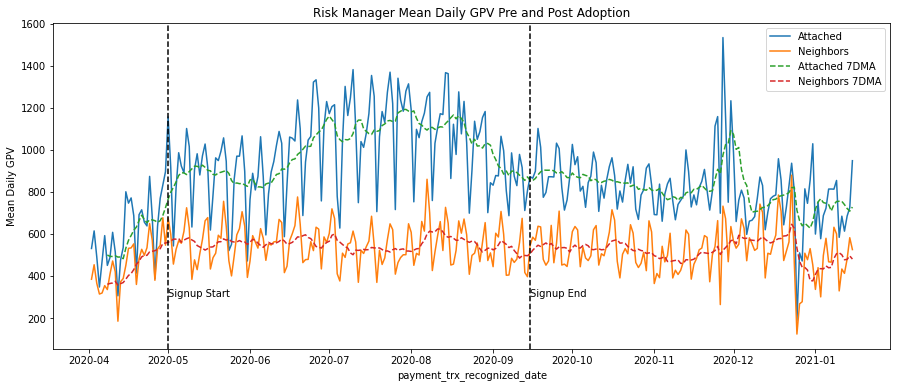

In [237]:
ts_attached = (RiskManager_lookalike.attached_measurement.groupby('payment_trx_recognized_date').gpv_post.sum()) / len(RiskManager_lookalike.neighbors_result)
ts_neighbors = (RiskManager_lookalike.neighbors_measurement.groupby('payment_trx_recognized_date').weighted_gpv_post.sum()) / len(RiskManager_lookalike.neighbors_result)

ts_attached.plot(label='Attached')
ts_neighbors.plot(figsize=(15,6), label='Neighbors')

ts_attached.rolling(window=7, min_periods=7).mean().plot(label='Attached 7DMA', linestyle='--')
ts_neighbors.rolling(window=7, min_periods=7).mean().plot(label='Neighbors 7DMA', linestyle='--')

plt.title('Risk Manager Mean Daily GPV Pre and Post Adoption')
plt.axvline('2020-05-01', linestyle='--', c='k')
plt.annotate(xy=('2020-05-01', 300), text='Signup Start')
plt.ylabel('Mean Daily GPV')

plt.legend(loc=0)

plt.axvline('2020-09-15', linestyle='--', c='k')
plt.annotate(xy=('2020-09-15', 300), text='Signup End');

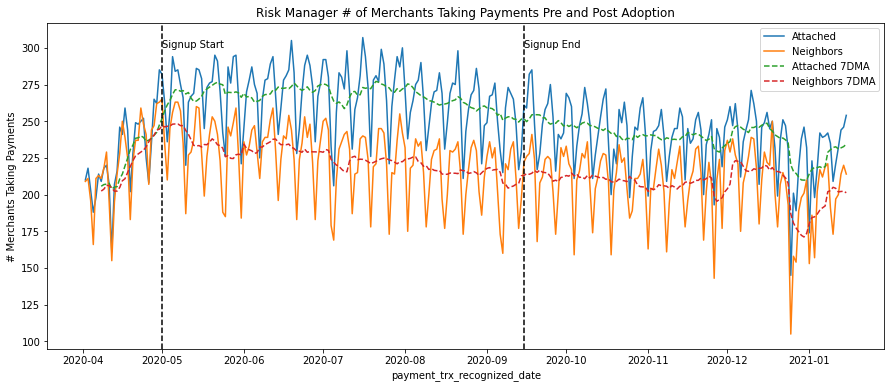

In [238]:
ts_attached = RiskManager_lookalike.attached_measurement.groupby('payment_trx_recognized_date').gpv_post.agg('count')
ts_neighbors = RiskManager_lookalike.neighbors_measurement.groupby('payment_trx_recognized_date').weight.sum()

ts_attached.plot(label='Attached')
ts_neighbors.plot(figsize=(15,6), label='Neighbors')

ts_attached.rolling(window=7, min_periods=7).mean().plot(label='Attached 7DMA', linestyle='--')
ts_neighbors.rolling(window=7, min_periods=7).mean().plot(label='Neighbors 7DMA', linestyle='--')

plt.title('Risk Manager # of Merchants Taking Payments Pre and Post Adoption')
plt.axvline('2020-05-01', linestyle='--', c='k')
plt.annotate(xy=('2020-05-01', 300), text='Signup Start')
plt.ylabel('# Merchants Taking Payments')

plt.legend(loc=0)

plt.axvline('2020-09-15', linestyle='--', c='k')
plt.annotate(xy=('2020-09-15', 300), text='Signup End');

In [ ]:
q = """
    SELECT
      cb.user_token AS best_available_merchant_token
    , cb.PAYMENT_CREATED_AT
    , SUM(chargeback_cents)/100 AS chargebacks 
    , SUM(loss_cents)/100 AS loss  
    FROM app_risk.app_risk.chargebacks cb 
    WHERE cb.user_token IN ({tokens})
      AND cb.PAYMENT_CREATED_AT > DATE('{SIMILARITY_DATE}') - INTERVAL '30 days'
      AND cb.PAYMENT_CREATED_AT <= '{POST_MEASUREMENT_DATE}'
      AND CB.type = 'fraud'
    GROUP BY 1,2
"""
RiskManager_lookalike.measurement_query = q
RiskManager_lookalike.neighbors_result
print(len(RiskManager_lookalike.neighbors_result))
RiskManager_lookalike.find_result()

In [ ]:
ts_attached = (RiskManager_lookalike.attached_measurement.groupby('PAYMENT_CREATED_AT').chargebacks.sum()) / len(RiskManager_lookalike.neighbors_result)
ts_neighbors = (RiskManager_lookalike.neighbors_measurement.groupby('PAYMENT_CREATED_AT').chargebacks.sum()) / len(RiskManager_lookalike.neighbors_result)

ts_attached.plot(label='Attached')
ts_neighbors.plot(figsize=(15,6), label='Neighbors')

ts_attached.rolling(window=7, min_periods=7).mean().plot(label='Attached 7DMA', linestyle='--')
ts_neighbors.rolling(window=7, min_periods=7).mean().plot(label='Neighbors 7DMA', linestyle='--')

plt.title('Risk Manager Mean Daily GPV Pre and Post Adoption')
plt.axvline('2020-05-01', linestyle='--', c='k')
plt.annotate(xy=('2020-05-01', 300), text='Signup Start')
plt.ylabel('Mean Daily GPV')

plt.legend(loc=0)

plt.axvline('2020-09-15', linestyle='--', c='k')
plt.annotate(xy=('2020-09-15', 300), text='Signup End');

In [230]:
dfx1 = RiskManager_lookalike.neighbors_result.to_frame().reset_index().rename(columns={'best_available_merchant_token': 'attached_token', 0: 'neighbor_token'})
dfx1.head()

,attached_token,neighbor_token
0,D2BHY6VMP3RMH,RPR495Y6GVFXT
1,2VZ1HQEQFH9T3,4X5A862159537
2,2FPHR86YJVSW2,4CJ9FR31ZMHSY
3,588TYQWSHDKS4,7X2WP7YXSS4ZJ
4,X2R649J61W5DW,MRGAT9BRCE4RP


In [275]:
with Session() as ss:
    ss.execute("""DROP TABLE IF EXISTS app_risk.app_risk_test.nmavani_riskmanager_lookalike;""")

write_df_to_snowflake(dfx1, 'app_risk', 'app_risk_test', 'nmavani_riskmanager_lookalike')

In [240]:
with Session() as ss:
    mcc_df = ss.execute("""SELECT cl.attached_token
    , cl.neighbor_token
    , du1.business_category AS attached_mcc
    , du2.business_category AS neighbor_mcc
    , CASE WHEN attached_mcc = neighbor_mcc THEN 1 ELSE 0 END AS same_mcc
FROM app_risk.app_risk_test.nmavani_riskmanager_lookalike cl
LEFT JOIN app_bi.pentagon.dim_user du1
    ON cl.attached_token = du1.user_token
LEFT JOIN app_bi.pentagon.dim_user du2
    ON cl.neighbor_token = du2.user_token
;""")

In [241]:
print(mcc_df.same_mcc.sum())
print(mcc_df.same_mcc.sum()/len(mcc_df))

397
0.8428874734607219


In [269]:
with Session() as ss:
    ss.execute("""


CREATE OR REPLACE TABLE app_risk.app_risk_test.nmavani_riskmanager_lookalike_s1
AS
WITH ATT_CB AS(
SELECT attached_token
    , neighbor_token
    , SUM(CASE WHEN c1.payment_created_at BETWEEN DATE('2020-05-01') - INTERVAL '27 days' AND DATE('2020-05-01') THEN c1.chargeback_cents/100 ELSE 0 END) AS att_cb_pre
    , SUM(CASE WHEN c1.payment_created_at BETWEEN DATE('2020-05-01') - INTERVAL '27 days' AND DATE('2020-05-01') THEN c1.loss_cents/100 ELSE 0 END) AS att_loss_pre
    , SUM(CASE WHEN c1.payment_created_at BETWEEN DATE('2021-01-15') - INTERVAL '27 days' AND DATE('2021-01-15') THEN c1.chargeback_cents/100 ELSE 0 END) AS att_cb_post
    , SUM(CASE WHEN c1.payment_created_at BETWEEN DATE('2021-01-15') - INTERVAL '27 days' AND DATE('2021-01-15') THEN c1.loss_cents/100 ELSE 0 END) AS att_loss_post
FROM app_risk.app_risk_test.nmavani_riskmanager_lookalike cl
LEFT JOIN app_risk.app_risk.chargebacks c1
    ON cl.attached_token = c1.user_token AND c1.type = 'fraud'
GROUP BY 1,2
),
NEIGH_CB AS
(SELECT attached_token
    , neighbor_token 
    , SUM(CASE WHEN c2.payment_created_at BETWEEN DATE('2020-05-01') - INTERVAL '27 days' AND DATE('2020-05-01') THEN c2.chargeback_cents/100 ELSE 0 END) AS neigh_cb_pre    
    , SUM(CASE WHEN c2.payment_created_at BETWEEN DATE('2020-05-01') - INTERVAL '27 days' AND DATE('2020-05-01') THEN c2.loss_cents/100 ELSE 0 END) AS neigh_loss_pre
    , SUM(CASE WHEN c2.payment_created_at BETWEEN DATE('2021-01-15') - INTERVAL '27 days' AND DATE('2021-01-15') THEN c2.chargeback_cents/100 ELSE 0 END) AS neigh_cb_post
    , SUM(CASE WHEN c2.payment_created_at BETWEEN DATE('2021-01-15') - INTERVAL '27 days' AND DATE('2021-01-15') THEN c2.loss_cents/100 ELSE 0 END) AS neigh_loss_post
FROM app_risk.app_risk_test.nmavani_riskmanager_lookalike cl    
LEFT JOIN app_risk.app_risk.chargebacks c2
    ON cl.neighbor_token = c2.user_token AND c2.type = 'fraud'
GROUP BY 1,2)
SELECT distinct s1.attached_token
    , s1.neighbor_token
    , ATT_CB.att_cb_pre
    , ATT_CB.att_cb_post
    , NEIGH_CB.neigh_cb_pre
    , NEIGH_CB.neigh_cb_post
    , ATT_CB.att_loss_pre
    , ATT_CB.att_loss_post
    , NEIGH_CB.neigh_loss_pre
    , NEIGH_CB.neigh_loss_post
FROM app_risk.app_risk_test.nmavani_riskmanager_lookalike s1
LEFT JOIN ATT_CB
    ON s1.attached_token = ATT_CB.attached_token
LEFT JOIN NEIGH_CB
    ON s1.neighbor_token = NEIGH_CB.neighbor_token
;

CREATE OR REPLACE TABLE app_risk.app_risk_test.nmavani_riskmanager_lookalike_s2
AS
WITH att_base
AS
(SELECT attached_token
    , SUM(CASE WHEN asdps1.payment_trx_recognized_date BETWEEN DATE('2020-05-01') - INTERVAL '27 days' AND DATE('2020-05-01') THEN asdps1.gpv_payment_amount_base_unit_usd/100 ELSE 0 END) AS att_gpv_pre
    , SUM(CASE WHEN asdps1.payment_trx_recognized_date BETWEEN DATE('2021-01-15') - INTERVAL '27 days' AND DATE('2021-01-15') THEN asdps1.gpv_payment_amount_base_unit_usd/100 ELSE 0 END) AS att_gpv_post
    , SUM(CASE WHEN asdps1.payment_trx_recognized_date BETWEEN DATE('2020-05-01') - INTERVAL '27 days' AND DATE('2020-05-01') THEN asdps1.gpv_payment_count ELSE 0 END) AS att_pmtcnt_pre
    , SUM(CASE WHEN asdps1.payment_trx_recognized_date BETWEEN DATE('2021-01-15') - INTERVAL '27 days' AND DATE('2021-01-15') THEN asdps1.gpv_payment_count ELSE 0 END) AS att_pmtcnt_post
FROM app_risk.app_risk_test.nmavani_riskmanager_lookalike_s1 s1
LEFT JOIN app_bi.pentagon.aggregate_seller_daily_payment_summary asdps1
    ON s1.attached_token = asdps1.user_token AND asdps1.payment_trx_recognized_date BETWEEN '2020-04-01' AND '2021-01-15'
GROUP BY 1)
, neigh_base
AS
(SELECT neighbor_token
    , SUM(CASE WHEN asdps2.payment_trx_recognized_date BETWEEN DATE('2020-05-01') - INTERVAL '27 days' AND DATE('2020-05-01') THEN asdps2.gpv_payment_amount_base_unit_usd/100 ELSE 0 END) AS neigh_gpv_pre
    , SUM(CASE WHEN asdps2.payment_trx_recognized_date BETWEEN DATE('2021-01-15') - INTERVAL '27 days' AND DATE('2021-01-15') THEN asdps2.gpv_payment_amount_base_unit_usd/100 ELSE 0 END) AS neigh_gpv_post
    , SUM(CASE WHEN asdps2.payment_trx_recognized_date BETWEEN DATE('2020-05-01') - INTERVAL '27 days' AND DATE('2020-05-01') THEN asdps2.gpv_payment_count ELSE 0 END) AS neigh_pmtcnt_pre
    , SUM(CASE WHEN asdps2.payment_trx_recognized_date BETWEEN DATE('2021-01-15') - INTERVAL '27 days' AND DATE('2021-01-15') THEN asdps2.gpv_payment_count ELSE 0 END) AS neigh_pmtcnt_post
FROM app_risk.app_risk_test.nmavani_riskmanager_lookalike_s1 s1
LEFT JOIN app_bi.pentagon.aggregate_seller_daily_payment_summary asdps2
    ON s1.neighbor_token = asdps2.user_token AND asdps2.payment_trx_recognized_date BETWEEN '2020-04-01' AND '2021-01-15'
GROUP BY 1)
SELECT distinct s1.attached_token
    , s1.neighbor_token
    , s1.att_cb_pre
    , s1.att_cb_post
    , s1.neigh_cb_pre
    , s1.neigh_cb_post
    , s1.att_loss_pre
    , s1.att_loss_post
    , s1.neigh_loss_pre
    , s1.neigh_loss_post
    , att_base.att_gpv_pre
    , att_base.att_gpv_post
    , neigh_base.neigh_gpv_pre
    , neigh_base.neigh_gpv_post
    , att_base.att_pmtcnt_pre
    , att_base.att_pmtcnt_post
    , neigh_base.neigh_pmtcnt_pre
    , neigh_base.neigh_pmtcnt_post
FROM app_risk.app_risk_test.nmavani_riskmanager_lookalike_s1 s1
LEFT JOIN att_base
    ON s1.attached_token = att_base.attached_token
LEFT JOIN neigh_base
    ON s1.neighbor_token = neigh_base.neighbor_token
;




CREATE OR REPLACE TABLE app_risk.app_risk_test.nmavani_riskmanager_lookalike_s3
AS
WITH att_rev
AS
(SELECT s2.attached_token
    , SUM(CASE WHEN vrs1.report_date BETWEEN DATE('2020-05-01') - INTERVAL '27 days' AND DATE('2020-05-01') THEN vrs1.adjusted_revenue_fxd_usd ELSE 0 END) AS att_ar_pre
    , SUM(CASE WHEN vrs1.report_date BETWEEN DATE('2021-01-15') - INTERVAL '27 days' AND DATE('2021-01-15') THEN vrs1.adjusted_revenue_fxd_usd ELSE 0 END) AS att_ar_post
FROM app_risk.app_risk_test.nmavani_riskmanager_lookalike_s2 s2
LEFT JOIN app_bi.app_bi_dw.vfact_revenue_summary vrs1
    ON s2.attached_token = vrs1.user_token
GROUP BY 1)
, neigh_rev
AS
(SELECT s2.neighbor_token
    , SUM(CASE WHEN vrs2.report_date BETWEEN DATE('2020-05-01') - INTERVAL '27 days' AND DATE('2020-05-01') THEN vrs2.adjusted_revenue_fxd_usd ELSE 0 END) AS neigh_ar_pre
    , SUM(CASE WHEN vrs2.report_date BETWEEN DATE('2021-01-15') - INTERVAL '27 days' AND DATE('2021-01-15') THEN vrs2.adjusted_revenue_fxd_usd ELSE 0 END) AS neigh_ar_post
FROM app_risk.app_risk_test.nmavani_riskmanager_lookalike_s2 s2
LEFT JOIN app_bi.app_bi_dw.vfact_revenue_summary vrs2
    ON s2.neighbor_token = vrs2.user_token
GROUP BY 1)
SELECT  distinct s2.attached_token
            , s2.neighbor_token
            , s2.att_cb_pre
            , s2.att_cb_post
            , s2.neigh_cb_pre
            , s2.neigh_cb_post
            , s2.att_loss_pre
            , s2.att_loss_post
            , s2.neigh_loss_pre
            , s2.neigh_loss_post
            , s2.att_gpv_pre
            , s2.att_gpv_post
            , s2.neigh_gpv_pre
            , s2.neigh_gpv_post
            , s2.att_pmtcnt_pre
            , s2.att_pmtcnt_post
            , s2.neigh_pmtcnt_pre
            , s2.neigh_pmtcnt_post
            , ar.att_ar_pre
            , ar.att_ar_post
            , nr.neigh_ar_pre
            , nr.neigh_ar_post
FROM app_risk.app_risk_test.nmavani_riskmanager_lookalike_s2 s2
LEFT JOIN att_rev ar
    ON s2.attached_token = ar.attached_token
LEFT JOIN neigh_rev nr
    ON s2.neighbor_token = nr.neighbor_token
;


CREATE OR REPLACE TABLE app_risk.app_risk_test.nmavani_riskmanager_lookalike_s4
AS
WITH att_misc
AS
(SELECT s2.attached_token
    , MAX(CASE WHEN vrs1.PAYMENT_TRX_RECOGNIZED_DATE BETWEEN DATE('2021-01-15') - INTERVAL '90 days' AND DATE('2021-01-15') THEN 1 ELSE 0 END) AS att_active_post
    , SUM(CASE WHEN DECLINE_REASONS ILIKE '%RISK%' OR DECLINE_REASONS ILIKE '%MERCHANT_CONFIGURED%' THEN AUTH_INTENT_AMOUNT ELSE 0 END) AS att_decline_gpv_post
FROM app_risk.app_risk_test.nmavani_riskmanager_lookalike_s3 s2
LEFT JOIN app_bi.pentagon.aggregate_seller_daily_payment_summary vrs1
    ON s2.attached_token = vrs1.user_token
LEFT JOIN PAYMENTS_DW.PUBLIC.PAYMENT_TRANSACTIONS DW 
    ON AUTH_INTENT_CREATED_AT BETWEEN DATE('2021-01-15') - INTERVAL '27 days' AND DATE('2021-01-15') 
    AND  DW.unit_TOKEN = S2.ATTAched_token
    AND IS_GPV = 0
    AND IS_CARD_PAYMENT = 1
GROUP BY 1)
, neigh_misc
AS
(SELECT s2.neighbor_token
    , MAX(CASE WHEN vrs1.PAYMENT_TRX_RECOGNIZED_DATE BETWEEN DATE('2021-01-15') - INTERVAL '90 days' AND DATE('2021-01-15') THEN 1 ELSE 0 END) AS neigh_active_post
    , SUM(CASE WHEN DECLINE_REASONS ILIKE '%RISK%' OR DECLINE_REASONS ILIKE '%MERCHANT_CONFIGURED%' THEN AUTH_INTENT_AMOUNT ELSE 0 END) AS neigh_decline_gpv_post
FROM app_risk.app_risk_test.nmavani_riskmanager_lookalike_s3 s2
LEFT JOIN app_bi.pentagon.aggregate_seller_daily_payment_summary vrs1
    ON s2.neighbor_token = vrs1.user_token
LEFT JOIN PAYMENTS_DW.PUBLIC.PAYMENT_TRANSACTIONS DW 
    ON AUTH_INTENT_CREATED_AT BETWEEN DATE('2021-01-15') - INTERVAL '27 days' AND DATE('2021-01-15') 
     AND DW.unit_TOKEN = S2.neighbor_token
    AND IS_GPV = 0
    AND IS_CARD_PAYMENT = 1
GROUP BY 1)
SELECT distinct s3.*
       ,ar.att_active_post
       , ar.att_decline_gpv_post
       , nr.neigh_decline_gpv_post
       , nr.neigh_active_post
FROM app_risk.app_risk_test.nmavani_riskmanager_lookalike_s3 s3
LEFT JOIN att_misc ar
    ON s3.attached_token = ar.attached_token
LEFT JOIN neigh_misc nr
    ON s3.neighbor_token = nr.neighbor_token
;





CREATE OR REPLACE TABLE app_risk.app_risk_test.nmavani_riskmanager_lookalike_final_raw
AS
SELECT COUNT(attached_token) AS num_attached
    , COUNT(neighbor_token) AS num_neighbors
    , SUM(att_active_post) as attached_active_post
    , SUM(neigh_active_post) as neighbor_active_post 
    , SUM(att_cb_pre) AS attached_chargebacks_pre
    , SUM(att_cb_post) AS attached_chargebacks_post
    , SUM(neigh_cb_pre) AS neighbor_chargebacks_pre
    , SUM(neigh_cb_post) AS neighbor_chargebacks_post
    , SUM(att_loss_pre) AS attached_loss_pre
    , SUM(att_loss_post) AS attached_loss_post
    , SUM(neigh_loss_pre) AS neighbor_loss_pre
    , SUM(neigh_loss_post) AS neighbor_loss_post
    , SUM(att_gpv_pre) AS attached_gpv_pre
    , SUM(att_gpv_post) AS attached_gpv_post
    , SUM(neigh_gpv_pre) AS neighbor_gpv_pre
    , SUM(neigh_gpv_post) AS neighbor_gpv_post  
    , SUM(att_pmtcnt_pre) AS attached_pmtcnt_pre
    , SUM(att_pmtcnt_post) AS attached_pmtcnt_post
    , SUM(neigh_pmtcnt_pre) AS neighbor_pmtcnt_pre
    , SUM(neigh_pmtcnt_post) AS neighbor_pmtcnt_post
    , SUM(att_ar_pre) AS attached_ar_pre
    , SUM(att_ar_post) AS attached_ar_post
    , SUM(neigh_ar_pre) AS neighbor_ar_pre
    , SUM(neigh_ar_post) AS neighbor_ar_post
    ,SUM(att_decline_gpv_post) as attached_decline_gpv_post
    , SUM(neigh_decline_gpv_post) as neighbor_decline_gpv_post
FROM app_risk.app_risk_test.nmavani_riskmanager_lookalike_s4 s3
;

CREATE OR REPLACE TABLE app_risk.app_risk_test.nmavani_riskmanager_lookalike_final_avg
AS
SELECT attached_chargebacks_pre / num_attached AS avg_attached_chargebacks_pre
    , attached_chargebacks_post / num_attached AS avg_attached_chargebacks_post
    , neighbor_chargebacks_pre / num_neighbors AS avg_neighbor_chargebacks_pre
    , neighbor_chargebacks_post / num_neighbors AS avg_neighbor_chargebacks_post
    , attached_loss_pre / num_attached AS avg_attached_loss_pre
    , attached_loss_post / num_attached AS avg_attached_loss_post
    , neighbor_loss_pre / num_neighbors AS avg_neighbor_loss_pre
    , neighbor_loss_post / num_neighbors AS avg_neighbor_loss_post
    , attached_gpv_pre / num_attached AS avg_attached_gpv_pre
    , attached_gpv_post / num_attached AS avg_attached_gpv_post
    , neighbor_gpv_pre / num_neighbors AS avg_neighbor_gpv_pre
    , neighbor_gpv_post / num_neighbors AS avg_neighbor_gpv_post
    , attached_pmtcnt_pre / num_attached AS avg_attached_pmtcnt_pre
    , attached_pmtcnt_post / num_attached AS avg_attached_pmtcnt_post
    , neighbor_pmtcnt_pre / num_neighbors AS avg_neighbor_pmtcnt_pre
    , neighbor_pmtcnt_post / num_neighbors AS avg_neighbor_pmtcnt_post
    , attached_gpv_pre / attached_pmtcnt_pre AS attached_avgticket_pre
    , attached_gpv_post / attached_pmtcnt_pre AS attached_avgticket_post
    , neighbor_gpv_pre / neighbor_pmtcnt_pre AS neighbor_avgticket_pre
    , neighbor_gpv_post / neighbor_pmtcnt_pre AS neighbor_avgticket_post
    , attached_ar_pre / num_attached AS avg_attached_ar_pre
    , attached_ar_post / num_attached AS avg_attached_ar_post
    , neighbor_ar_pre / num_neighbors AS avg_neighbor_ar_pre
    , neighbor_ar_post / num_neighbors AS avg_neighbor_ar_post
    , attached_active_post/ num_attached as attached_retained_post_perc
    , neighbor_active_post/ num_neighbors as neighbor_retained_post_perc
    , attached_decline_gpv_post/ num_attached as avg_attached_declined_post
    , neighbor_decline_gpv_post/ num_neighbors as avg_neighbor_retained_post
    , attached_chargebacks_pre*10000/ attached_gpv_pre as avg_attached_chargeback_rate_pre
    , attached_chargebacks_post*10000/ attached_gpv_post as avg_attached_chargeback_rate_post
    , neighbor_chargebacks_pre*10000/ neighbor_gpv_pre as avg_neighbor_chargeback_rate_pre
    , neighbor_chargebacks_post*10000/ neighbor_gpv_post as avg_neighbor_chargeback_rate_post
    , attached_loss_pre*10000/ attached_gpv_pre as avg_attached_loss_rate_pre
    , attached_loss_post*10000/ attached_gpv_post as avg_attached_loss_rate_post
    , neighbor_loss_pre*10000/ neighbor_gpv_pre as avg_neighbor_loss_rate_pre
    , neighbor_loss_post*10000/ neighbor_gpv_post as avg_neighbor_loss_rate_post
    
FROM app_risk.app_risk_test.nmavani_riskmanager_lookalike_final_raw
;

""")
 




In [270]:
with Session() as ss:
    dfx2 = ss.execute("""SELECT *
        FROM app_risk.app_risk_test.nmavani_riskmanager_lookalike_final_raw
        ;""")
    
    dfx3 = ss.execute("""SELECT *
        FROM app_risk.app_risk_test.nmavani_riskmanager_lookalike_final_avg
        ;""")
    
    dfx4 = ss.execute("""SELECT *
        FROM app_risk.app_risk_test.nmavani_riskmanager_lookalike_s4
        ;""")

In [271]:
dfx4

,attached_token,neighbor_token,att_cb_pre,att_cb_post,neigh_cb_pre,neigh_cb_post,att_loss_pre,att_loss_post,neigh_loss_pre,neigh_loss_post,att_gpv_pre,att_gpv_post,...,att_pmtcnt_pre,att_pmtcnt_post,neigh_pmtcnt_pre,neigh_pmtcnt_post,att_ar_pre,att_ar_post,neigh_ar_pre,neigh_ar_post,att_active_post,att_decline_gpv_post,neigh_decline_gpv_post,neigh_active_post
0,4RYM3MMYVNNNN,1R4V2KPCTADX3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,40086.09,108541.41,...,1077,2845,365,1507,280.41,767.13,191.43,428.30,1,12708095,0,1
1,SD8B2WKWPAYJF,7SN1PE7SNKG91,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7100.00,0.00,...,196,0,3,7,153.14,0.00,1.87,3.63,1,0,0,1
2,HF3EQ2WXW278D,K3XPWSHMQX7CN,0.00,52.97,0.00,0.00,0.00,0.00,0.00,0.00,1854.09,72154.09,...,30,815,24,8,39.91,1324.21,30.98,25.90,1,36383072,0,1
3,G4WN5KH6X248E,VY88NFXRD0N3B,0.00,197.01,0.00,0.00,0.00,0.00,0.00,0.00,4407.38,7115.13,...,119,163,51,37,93.40,146.03,84.11,98.82,1,23570262,0,1
4,8307C6X43HZ8W,FPGHNPGQKJDT2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,275.00,75.00,...,1,1,1,0,7.54,2.41,3.48,0.00,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,H2MZ0FTSXTYD3,SNVG90RTPENVF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9000.00,48229.00,...,3,13,2,0,132.16,372.55,3.88,0.00,1,0,0,0
467,84BG23721JHPR,K6WBGTWKXGF8G,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.18,0.00,...,3,0,3,2,-0.36,0.00,1.04,1.67,1,0,0,1
468,DYD9EDFFYAJ3Q,40HZH30ZYA2X5,334.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16831.48,6820.73,...,431,148,401,2,323.73,150.81,554.25,75.05,1,3379464,0,1
469,18VQH5AT3N0YE,8P0KP0AY4Q5T0,4398.00,10493.00,0.00,0.00,0.00,0.00,0.00,0.00,89438.88,98965.41,...,67,37,87,3,374.20,293.13,648.28,24.50,1,117521600,0,1


In [272]:
dfx2.T

,0
num_attached,471.00
num_neighbors,471.00
attached_active_post,422.00
neighbor_active_post,424.00
attached_chargebacks_pre,69277.98
attached_chargebacks_post,44406.33
neighbor_chargebacks_pre,7782.17
neighbor_chargebacks_post,5183.33
attached_loss_pre,2000.35
attached_loss_post,843.52


In [274]:
dfx3.T

,0
avg_attached_chargebacks_pre,147.09
avg_attached_chargebacks_post,94.28
avg_neighbor_chargebacks_pre,16.52
avg_neighbor_chargebacks_post,11.00
avg_attached_loss_pre,4.25
avg_attached_loss_post,1.79
avg_neighbor_loss_pre,0.10
avg_neighbor_loss_post,0.29
avg_attached_gpv_pre,17625.61
avg_attached_gpv_post,20281.34


In [299]:
def compare_buckets(bucket_list):
    new_df = dfx4[bucket_list]
    fig_dims = (5, 5)
    fig, ax = plt.subplots(figsize=fig_dims)
    ymin, ymax = -0.001, 0.009
    ax.set_ylim([ymin,ymax])
    a = sns.boxplot(data=new_df, showfliers=False)

In [249]:
## GPV
attached_gpv_pre = dfx4.att_gpv_pre
neighbor_gpv_pre = dfx4.neigh_gpv_pre
attached_gpv_post = dfx4.att_gpv_post
neighbor_gpv_post = dfx4.neigh_gpv_post
ks_2samp(attached_gpv_pre, neighbor_gpv_pre)
ks_2samp(attached_gpv_post, neighbor_gpv_post)

print(f'Pre GPV KSTest: {ks_2samp(attached_gpv_pre, neighbor_gpv_pre)} \n', f'Post GPV KSTest: {ks_2samp(attached_gpv_post, neighbor_gpv_post)} \n')

Pre GPV KSTest: KstestResult(statistic=0.06157112526539278, pvalue=0.3340978232355536) 
 Post GPV KSTest: KstestResult(statistic=0.08917197452229299, pvalue=0.04721335135208378) 



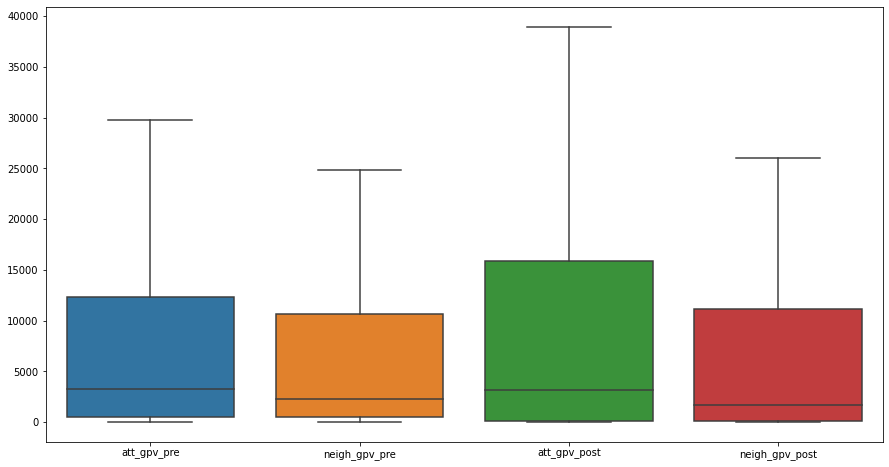

In [250]:
gpv_cols = ['att_gpv_pre','neigh_gpv_pre', 'att_gpv_post', 'neigh_gpv_post']
compare_buckets(gpv_cols)

In [251]:
## Adjusted Revenue
attached_ar_pre = dfx4.att_ar_pre
neighbor_ar_pre = dfx4.neigh_ar_pre
attached_ar_post = dfx4.att_ar_post
neighbor_ar_post = dfx4.neigh_ar_post
ks_2samp(attached_ar_pre, neighbor_ar_pre)
ks_2samp(attached_ar_post, neighbor_ar_post)

print(f'Pre GPV KSTest: {ks_2samp(attached_ar_pre, neighbor_ar_pre)} \n', f'Post GPV KSTest: {ks_2samp(attached_ar_post, neighbor_ar_post)} \n')

Pre AR KSTest: KstestResult(statistic=0.04670912951167728, pvalue=0.6836818370285075) 
 Post GPV KSTest: KstestResult(statistic=0.10191082802547771, pvalue=0.01496772018550982) 



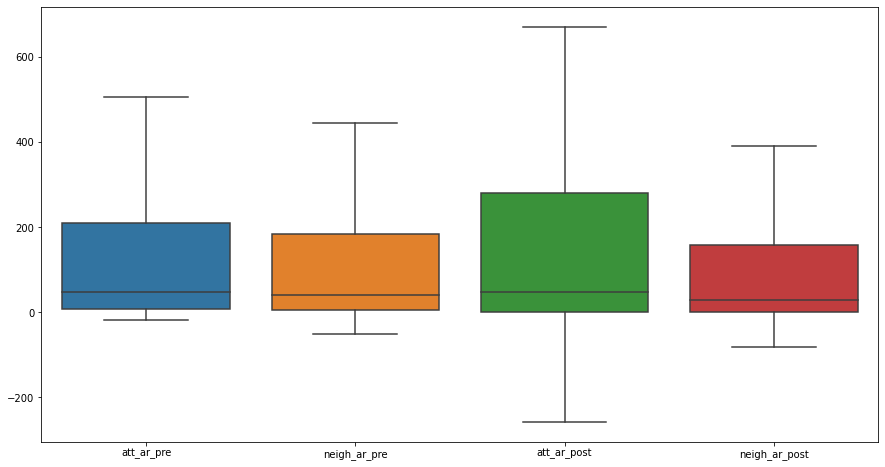

In [252]:
ar_cols = ['att_ar_pre','neigh_ar_pre', 'att_ar_post','neigh_ar_post']
compare_buckets(ar_cols)

In [276]:
## Payment Count
attached_pmtcnt_pre = dfx4.att_pmtcnt_pre
neighbor_pmtcnt_pre = dfx4.neigh_pmtcnt_pre
attached_pmtcnt_post = dfx4.att_pmtcnt_post
neighbor_pmtcnt_post = dfx4.neigh_pmtcnt_post

ks_2samp(attached_pmtcnt_pre, neighbor_pmtcnt_pre)
ks_2samp(attached_pmtcnt_post, neighbor_pmtcnt_post)

print(f'Pre Payment count KSTest: {ks_2samp(attached_pmtcnt_pre, neighbor_pmtcnt_pre)} \n', f'Post Payment coun KSTest: {ks_2samp(attached_pmtcnt_post, neighbor_pmtcnt_post)} \n')

Pre Payment count KSTest: KstestResult(statistic=0.029723991507430998, pvalue=0.9855584971501181) 
 Post Payment coun KSTest: KstestResult(statistic=0.06369426751592357, pvalue=0.2951874450005313) 



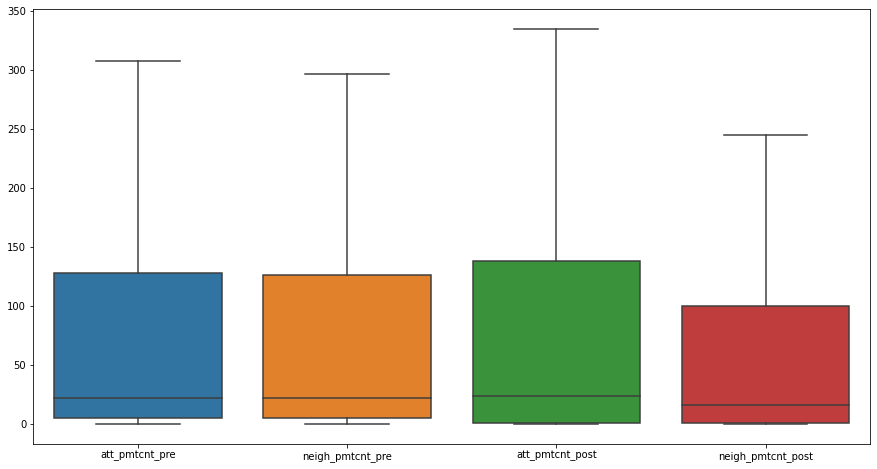

In [254]:
pmtcnt_cols = ['att_pmtcnt_pre','neigh_pmtcnt_pre', 'att_pmtcnt_post','neigh_pmtcnt_post']
compare_buckets(pmtcnt_cols)

In [295]:
## Chargebacks
attached_cb_pre = dfx4.att_cb_pre
neighbor_cb_pre = dfx4.neigh_cb_pre
ks_2samp(attached_cb_pre, neighbor_cb_pre)

attached_cb_post = dfx4.att_cb_post
neighbor_cb_post = dfx4.neigh_cb_post
ks_2samp(attached_cb_post, neighbor_cb_post)

print(f'Pre CB KSTest: {ks_2samp(attached_cb_pre, neighbor_cb_pre)} \n', f'Post CB KSTest: {ks_2samp(attached_cb_post, neighbor_cb_post)} \n')

Pre CB KSTest: KstestResult(statistic=0.10191082802547771, pvalue=0.01496772018550982) 
 Post CB KSTest: KstestResult(statistic=0.07855626326963906, pvalue=0.10931779390312409) 



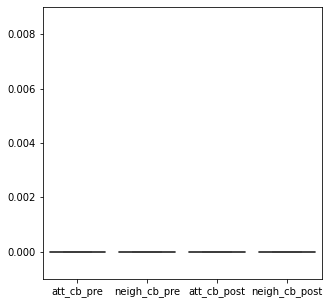

In [300]:
cb_cols = ['att_cb_pre','neigh_cb_pre', 'att_cb_post','neigh_cb_post']
compare_buckets(cb_cols)

In [255]:
## Loss
attached_loss_pre = dfx4.att_loss_pre
neighbor_loss_pre = dfx4.neigh_loss_pre
ks_2samp(attached_loss_pre, neighbor_loss_pre)

attached_loss_post = dfx4.att_loss_post
neighbor_loss_post = dfx4.neigh_loss_post
ks_2samp(attached_loss_post, neighbor_loss_post)

print(f'Pre Loss KSTest: {ks_2samp(attached_loss_pre, neighbor_loss_pre)} \n', f'Post Loss KSTest: {ks_2samp(attached_loss_post, neighbor_loss_post)} \n')

Pre Loss KSTest: KstestResult(statistic=0.0021231422505307855, pvalue=1.0) 
 Post Loss KSTest: KstestResult(statistic=0.006369426751592357, pvalue=0.9999999999999997) 



In [301]:
neighbor_loss_post

0     0.00
1     0.00
2     0.00
3     0.00
4     0.00
      ... 
466   0.00
467   0.00
468   0.00
469   0.00
470   0.00
Name: neigh_loss_post, Length: 471, dtype: float64

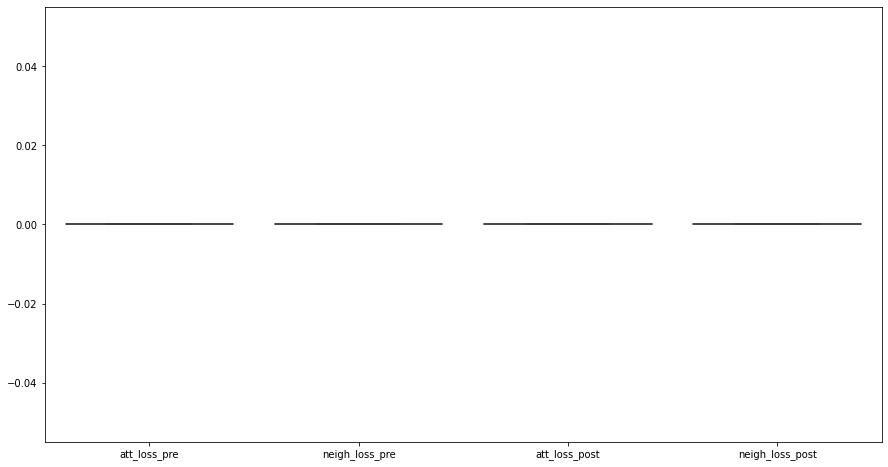

In [258]:
loss_cols = ['att_loss_pre','neigh_loss_pre','att_loss_post','neigh_loss_post']
compare_buckets(loss_cols)

In [278]:
dfx3.T

,0
avg_attached_chargebacks_pre,147.09
avg_attached_chargebacks_post,94.28
avg_neighbor_chargebacks_pre,16.52
avg_neighbor_chargebacks_post,11.00
avg_attached_loss_pre,4.25
avg_attached_loss_post,1.79
avg_neighbor_loss_pre,0.10
avg_neighbor_loss_post,0.29
avg_attached_gpv_pre,17625.61
avg_attached_gpv_post,20281.34


In [284]:
 def read_dumbo_values():
    all_data = blocks.assemble('gs://ds-risk-prod-snowstage/nmavani/lookalike/data_dumbo_filtered/results')
    all_data.dropna(axis='columns', how='all', inplace=True)
    all_data.is_attached_later =  all_data.is_attached_later.astype(int)
    return all_data
        #.all_data = all_data[signallist]
        
        
## Process data for NUll values, and transform into logged transformation for better handling distances for normalization
def process_data(all_data):
    pipe = Pipeline([
        ('median_imputer', SimpleImputer(strategy='median')),
        ('standard_scaler', StandardScaler()),
        ('variance_threshold', VarianceThreshold(threshold=.1)),
    ])
    non_numeric_cols = [
        'best_available_merchant_token',
        'first_attached_date',
        'is_attached_later',
        'signal_date',
        'unit_token',
        #'total_success_amount_b_in_26w_by_merchant_from_merchant_token',
        #'total_success_amount_b_in_52w_by_merchant_from_merchant_token'
    ]
    numeric_cols = [c for c in all_data.columns if c not in non_numeric_cols]
    df_wzero = all_data[numeric_cols]
    df_nozero = df_wzero.mask(df_wzero==0).fillna(0.0000000001)
    logged_df = np.log(df_nozero)

    new = pipe.fit_transform(
        logged_df
    )
    selected_features = [numeric_cols[i] for i in range(len(numeric_cols)) if pipe.steps[2][1].get_support()[i]]
    new_df = pd.DataFrame(new, columns=selected_features)
    new_df.index = all_data['best_available_merchant_token']
    processed_data = new_df
    return processed_data

In [285]:
all_data = read_dumbo_values()

In [286]:
processed_data = process_data(all_data)
processed_data.head()

,avg_capture_amount_by_merchant_from_merchant_token,total_amount_by_merchant_from_merchant_token,total_external_api_amount_by_merchant_from_merchant_token,total_success_amount_b_in_1w_by_merchant_from_merchant_token,total_success_amount_b_in_26w_by_merchant_from_merchant_token,total_success_amount_b_in_52w_by_merchant_from_merchant_token,total_success_amount_b_in_13w_by_merchant_from_merchant_token,total_success_amount_b_in_9w_by_merchant_from_merchant_token,total_success_amount_b_in_4w_by_merchant_from_merchant_token,total_declined_amount_by_merchant_from_merchant_token,total_declined_amount_b_in_4w_by_merchant_from_merchant_token,total_refund_amount_by_merchant_from_merchant_token,...,business_type_is_consultant_by_merchant_from_merchant_token,business_type_is_personal_services_by_merchant_from_merchant_token,business_type_is_apparel_and_accessory_shops_by_merchant_from_merchant_token,business_type_is_printing_services_by_merchant_from_merchant_token,business_type_is_education_by_merchant_from_merchant_token,business_type_is_eyewear_by_merchant_from_merchant_token,business_type_is_restaurants_by_merchant_from_merchant_token,business_type_is_dentistry_by_merchant_from_merchant_token,business_type_is_music_and_entertainment_by_merchant_from_merchant_token,business_type_is_misc_retail_by_merchant_from_merchant_token,business_type_is_movies_film_by_merchant_from_merchant_token,business_type_is_automotive_services_by_merchant_from_merchant_token
best_available_merchant_token,,,,,,,,,,,,,,,,,,,,,,,,,
M6R2WHMZ9G57C,0.01,-0.73,0.50,0.48,-0.41,-0.59,-0.30,-0.21,0.05,-2.47,-0.81,0.42,...,-0.15,-0.24,-0.08,-0.04,-0.12,-0.02,-0.22,-0.02,-0.13,3.39,-0.03,-0.04
T6YXHJQSAYAN3,0.05,-0.40,0.52,-1.60,-0.38,-0.46,-0.19,-0.23,-0.53,0.44,-0.81,-1.45,...,-0.15,-0.24,-0.08,-0.04,-0.12,-0.02,-0.22,-0.02,-0.13,3.39,-0.03,-0.04
7A095V8SES9FK,-0.27,0.61,0.56,0.71,0.64,0.70,0.54,0.47,0.40,0.39,1.13,0.55,...,-0.15,-0.24,-0.08,-0.04,-0.12,-0.02,-0.22,-0.02,-0.13,-0.30,-0.03,-0.04
00YTNEA71J963,-0.05,0.33,0.59,0.48,0.26,0.29,0.04,-0.18,-0.34,0.35,-0.81,0.67,...,-0.15,-0.24,-0.08,-0.04,-0.12,-0.02,-0.22,-0.02,-0.13,-0.30,-0.03,-0.04
4F6E3F0GPQNSZ,0.19,-0.47,0.58,0.71,-0.06,-0.24,0.13,0.23,0.43,-2.47,-0.81,0.67,...,-0.15,-0.24,-0.08,-0.04,-0.12,-0.02,-0.22,-0.02,-0.13,-0.30,-0.03,-0.04


In [287]:
attached = processed_data[all_data.set_index('best_available_merchant_token')['is_attached_later'] == 1]
non_attached = processed_data[all_data.set_index('best_available_merchant_token')['is_attached_later'] == 0]
distance_matrix = pd.DataFrame(euclidean_distances(attached, non_attached),
                               index=attached.index,
                               columns=non_attached.index)
neighbors_result = distance_matrix.apply(lambda x: x.idxmin(), axis=1)

In [288]:
distance_matrix.head()

best_available_merchant_token,M6R2WHMZ9G57C,T6YXHJQSAYAN3,7A095V8SES9FK,00YTNEA71J963,4F6E3F0GPQNSZ,DAV2QVF5GTAN6,P5D2RQJSPMB3N,EVN9Z3G1E2FGQ,48FPA39ZSJ5XS,63H1Y00RNG68T,2Z8153FG5PNT6,8NTDBMQNESWKK,...,70JH5CW57M1XV,0DP9Q8E5DDTS8,HQ2Z4FHB3KFPJ,JEYP0640V8ZAT,9VMZ97YGK2MZR,4S0BCNC8C7FJ8,1Z7XE9S2GHW0Z,FKMJ94M5K6Y3K,CMZS6WE71WAHS,B909YE6J0J2EZ,473BPGTJGZ2BG,T32JG5XEVYHQ5
best_available_merchant_token,,,,,,,,,,,,,,,,,,,,,,,,,
0P06PMXAE2RS5,20.87,20.84,20.63,20.99,22.79,21.30,22.40,20.64,37.53,20.59,21.38,21.07,...,21.62,24.04,23.54,21.28,23.48,21.72,32.87,21.51,21.23,22.46,24.47,20.78
WAT0DJDS3J6V7,10.93,10.76,9.66,10.62,14.20,11.27,13.31,8.90,34.12,9.80,11.87,10.77,...,10.45,15.90,15.43,11.30,13.49,12.76,28.81,11.86,8.87,13.54,13.37,8.28
23RW8EMGD9JH6,12.05,11.13,9.17,10.28,15.14,10.84,14.17,11.83,33.61,10.85,12.98,10.56,...,7.54,16.01,15.24,10.91,12.93,12.78,28.96,11.48,8.25,13.73,13.37,9.71
6ZSTEZKZ2HK05,8.24,6.35,6.97,7.08,12.63,4.81,12.29,7.27,30.23,7.94,10.00,6.82,...,7.98,14.04,12.11,7.66,12.62,7.82,24.07,7.55,8.08,11.00,15.09,8.81
01PRXSD3GDYXN,9.92,8.92,7.56,8.23,13.54,8.54,12.79,9.61,32.21,8.94,11.45,8.50,...,8.03,14.68,13.44,8.58,11.74,10.58,27.46,9.23,6.00,12.10,14.21,7.44


In [289]:
distance_matrix.apply(lambda x: x.idxmin(), axis=1)

best_available_merchant_token
0P06PMXAE2RS5    G4MKJWFE672MG
WAT0DJDS3J6V7    C18X28SCQNTP4
23RW8EMGD9JH6    MNZHGEZG0KH91
6ZSTEZKZ2HK05    8GPEY3EZAKPN0
01PRXSD3GDYXN    EMF2MXGX8ZFJJ
                     ...      
8YD6Y1X0KC2Q4    C8FXY5FC1FE37
3HQSFQ4PBBTM9    2S56RYH07FMZN
FH5Q8WNEC2C2K    BAVTBDVFPQB7D
D2BHY6VMP3RMH    RPR495Y6GVFXT
KWTBXFBHYW3DP    WYR2TTNVC6RAX
Length: 471, dtype: object

In [290]:
distance_matrix[:,distance_matrix[1,:].argsort()]

TypeError: '(1, slice(None, None, None))' is an invalid key